# Score compounds usign DeepDock

This notebook is an example of how to score compounds using DeepDock.

### Score a single ligand conformation usign DeepDock

Load required libraries for scoring compounds

In [1]:
from rdkit import Chem
import deepdock
from deepdock.models import *
from deepdock.docking_function import score_compound
from deepdock.docking_function import calculate_atom_contribution

import numpy as np
import torch
# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)

RDKit WARNING: [10:15:52] Enabling RDKit 2019.09.1 jupyter extensions


Define the DeepDock model to use

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

Load pretrained model.

In [3]:
checkpoint = torch.load(deepdock.__path__[0]+'/../Trained_models/DeepDock_pdbbindv2019_13K_minTestLoss.chk', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

Define the path to the .ply file containing the target mesh and load the ligand as RDKIT molecule. Ligands must have 3D coordinates in order to be scored.

**Important:** As with every docking software, DeepDock is very susceptible to ligand preparation. In general we recommend to use the same ligand preparation steps that were used to prepare the training data, in this case PDBbind. If that is not possible, at lease use mol2 produced by Corina for compound containg chemical groups with conjugated bonds (eg. carboxylates, phosphates, sulphates, etc) since bond deffinition can change and can have great impact on results.


In [4]:
target_ply = deepdock.__path__[0]+'/../data/1z6e_protein.ply'
real_mol = Chem.MolFromMol2File(deepdock.__path__[0]+'/../data/1z6e_ligand.mol2',sanitize=False, cleanupSubstructures=False)

This coode is just to visualize the ligand-target complex that will be scored

In [5]:
import py3Dmol
p = py3Dmol.view(width=400,height=400)
with open(deepdock.__path__[0]+'/../data/1z6e_protein.pdb') as ifile:
    target = "".join([x for x in ifile])
p.addModelsAsFrames(target)
p.addModel(Chem.MolToMolBlock(real_mol),'sdf')

tar = {'model':0}
lig_real = {'model':1}

p.setStyle(tar, {'cartoon': {'color':'gray'}})
#p.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, res)
p.setStyle(lig_real,{'stick':{}})

p.zoomTo()
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This is the command that actually scores the ligand-target complex using the DeepDock model defined above. The resulting score is the sum of all distance likelihoods between the ligadn atoms and target mesh nodes.

In [6]:
score = score_compound(real_mol, target_ply, model, dist_threshold=3., seed=123, device=device)
score

array([251.22074199])

You can calculate how every atom in the molecule is contributing to the score. This contribution is based on the likelihood of each particular atom to be interacting with the nodes surrounding it based on the output of the model. The folowwing like outputs these contributions and the score.

In [7]:
score, contributions = calculate_atom_contribution(real_mol, target_ply, model, dist_threshold=3., seed=123, device=device)
contributions

[array([ 3.81165671,  1.42358881,  5.42182576, 11.61215299,  4.98728106,
        11.28165011,  9.39690998,  8.77663086,  5.39076678,  1.44047918,
        20.85658908, 21.77309461, 21.0632205 , 12.05258018,  9.61994116,
         9.50207938, 13.14690215,  5.18159764,  3.37692012,  5.30591832,
         6.34218453,  4.07963694,  1.19272658,  1.5052898 ,  3.32357844,
         5.11200427,  3.10645535,  2.01345929,  5.91734333,  9.68061686,
        10.74295356,  4.87267326,  2.86315552,  0.8759973 ,  0.86187015,
         0.54276024,  1.96273869,  0.80352662])]

The contributions can be easily visualized using the following lines

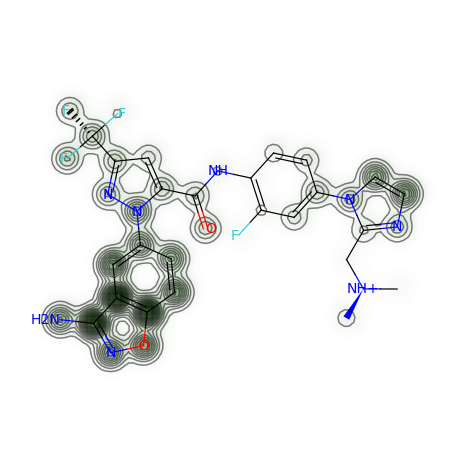

In [8]:
from rdkit.Chem.Draw import SimilarityMaps

mol_2d = Chem.RemoveHs(real_mol) #Remove hydrogens from the molecule since DeepDock doesn't take H's into account
mol_2d.RemoveAllConformers() # Creates a 2D visualization of the molecule
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol_2d, contributions[0], contourLines=20)

### Score compounds in batch usign DeepDock

You can also use DeepDock to score many ligand-target complexes at the same time which results in accelerates the process. For this we make use of the batch mode of in which sevelar complexes are feed into the model.

In [7]:
from torch_geometric.data import DataLoader
import pandas as pd

For this example we will use all complexes in CASF2-2016 previosuly prepared. The DataLoader takes the complexes and feed them into the model by groups. The size of the group (i.e. number of complexes scored at the same time) is given by the batch_size. This number depends on the computational resources availabe (mainly RAM) and the size of the target mesh.

In [8]:
casf2016 = torch.load(deepdock.__path__[0]+'/../data/dataset_CASF-2016_285.tar')
loader = DataLoader(casf2016, batch_size=20, shuffle=False)

This code just loops over the DataLoader making sure all complexes in groups of 20 are scored. At the end it groups the results in a pandas dataframe for easy visualization.

In [9]:
%%time
results = []

for data in loader:
    ligand, target, _, pdbid = data
    score = score_compound(ligand, target, model, dist_threshold=3., seed=123, device=device)
    results.append(np.concatenate([np.expand_dims(pdbid, axis=1), np.expand_dims(score, axis=1)], axis=1))

results = np.concatenate(results, axis=0)
results = pd.DataFrame(np.asarray(results), columns=['PDB_ID', 'Score'])
results.head()

CPU times: user 4min 25s, sys: 23 s, total: 4min 48s
Wall time: 1min 23s


PDB_ID               Score
0   4k18   64.25374156223134
1   4qac   83.28442756145884
2   1o3f  187.71326249501382
3   4ih7   35.63042398455328
4   3dx1   49.94478553628178

### Create your own database to do score in batch

You can also create a dataset to score compounds in batch. The following code shows how to prepare. your data to be used in this way.

First you need to list the path of your ligads mol2 and your target ply files.

In [10]:
pdb_list = ['2wtv', '2yge', '4f2w', '4ivd', '2br1']
mol_files = [deepdock.__path__[0]+'/../data/'+pdb+ '_ligand.mol2' for pdb in pdb_list]
target_files = [deepdock.__path__[0]+'/../data/'+pdb+ '_protein.ply' for pdb in pdb_list]

This code prepares the data set to be user by DeepDock directly. This can be modified as needed by specific projects.

In [11]:
from deepdock.utils.data import *

def prepare_data(mol_file, target_file, name):
    mol = Chem.MolFromMol2File(mol_file, sanitize=False, cleanupSubstructures=False)
    if mol is not None:
        mol = from_networkx(mol2graph.mol_to_nx(mol))
    else:
        mol = np.nan
    target = Cartesian()(FaceToEdge()(read_ply(target_file)))
    return mol, target, name
    
data = [prepare_data(m, t, n) for m, t, n in  zip(mol_files, target_files, pdb_list)]

As shown above this piece of code just set the DataLoader and makes a loop in order to score all compounds at the same time.

In [12]:
loader = DataLoader(data, batch_size=20, shuffle=False)
results = []

for data in loader:
    ligand, target, pdbid = data
    score = score_compound(ligand, target, model, dist_threshold=3., seed=123, device=device)
    results.append(np.concatenate([np.expand_dims(pdbid, axis=1), np.expand_dims(score, axis=1)], axis=1))

results = np.concatenate(results, axis=0)
results = pd.DataFrame(np.asarray(results), columns=['PDB_ID', 'Score'])
results.head()

PDB_ID               Score
0   2wtv   237.5239720551654
1   2yge   79.25612652227308
2   4f2w  179.33480891217908
3   4ivd  230.79213076899106
4   2br1  203.16007396610786